In [558]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import random
from tqdm import tqdm
from datetime import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from prince import FAMD

# 1. Finding Similar Costumers

## 1.1 Set up the data

In [306]:
# Load data
transactions = pd.read_csv('./data/bank_transactions.csv')
transactions.dropna(inplace=True)

# Formatting
transactions['CustomerDOB'] = pd.to_datetime(transactions['CustomerDOB'])

# Dropping unrealistic customers
transactions.drop(transactions.loc[transactions['CustomerDOB'].apply(lambda x: x.year) > 2022].index, axis=0, inplace=True)
transactions.drop(transactions.loc[transactions['CustomerDOB'].apply(lambda x: x.year) < 1900].index, axis=0, inplace=True)

# Convert INR to $
transactions['CustAccountBalance ($)'] = transactions['CustAccountBalance'].apply(lambda x: float(x) * 0.012)

# Calculate age
transactions['CustomerAge'] = (( pd.to_datetime('today') - transactions.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
transactions['CustomerAge'] = transactions['CustomerAge'].astype(int)

In order to perform the LSH Algorithm I chose to use the customers' gender, age and balance.

In [340]:
trans = transactions[['CustomerID', 'CustGender', 'CustomerAge', 'CustAccountBalance ($)']].groupby("CustomerID").last()

The last two features needs to be converted into a categorical format to be used.

In [341]:
trans['CustomerAgeCategory'] = pd.cut(trans['CustomerAge'],
                                 [min(trans['CustomerAge']) - 1,
                                 25, # Limit age for young
                                 50, # Limit age for adult
                                 max(trans['CustomerAge'])],
                                 labels=['young', 'adult', 'senior'])

In [342]:
trans['CustomerBalanceCategory'] = pd.cut(trans['CustAccountBalance ($)'],
                                 [-1,
                                 50, # Limit balance for poor
                                 500, # Limit balance for good
                                 max(trans['CustAccountBalance ($)'])],
                                 labels=['poor', 'good', 'wealthy'])

In [343]:
trans = trans[['CustGender', 'CustomerAgeCategory', 'CustomerBalanceCategory']]

In [344]:
# Prepare data to be encoded
values = [(i.split()) for i in trans.to_string(header=False, index=False, index_names=False).split('\n')]

# One Hot Encoding
one_hot = OneHotEncoder(dtype= bool, handle_unknown= "ignore", sparse= False)
one_hot = one_hot.fit(values)
matrix = one_hot.transform(values).T

## 1.2 Fingerprint hashing

In [415]:
def my_minhash(mat, n_permutation=10):

    random.seed(101)

    # Initialize output matrix
    signatures = np.zeros((n_permutation , mat.shape[1]))

    for i in tqdm(range(n_permutation)):

        np.random.shuffle(mat)

        # Get for each column the index of the first True value
        signatures[i, :] = [np.where(row == 1)[0][0] for row in mat.T]

    return signatures

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


In [ ]:
hashed_signatures = my_minhash(matrix)

In [427]:
def assign_bins(signatures, band_size=3):

    # Initialize output
    bins = {}

    # Loop each band (vertically)
    for i in range(signatures.shape[0] // band_size):

        # Get band rows
        band = signatures[i * band_size: (i+1) * band_size, :]

        # Loop each column (horizontally)
        for j, b in enumerate(band.T):

            # Create key if needed
            if str(b) not in bins.keys():
                bins[str(b)] = []

            # Add column to its bin
            bins[str(b)].append(j)

    return bins

In [428]:
bins = assign_bins(hashed_signatures)

## 1.3 Locality Sensitive Hashing

In [ ]:
# Load query data
query = pd.read_csv("data/query_users.csv" )

# Formatting
query['CustomerDOB'] = pd.to_datetime(query['CustomerDOB'])

# Convert INR to $
query['CustAccountBalance ($)'] = query['CustAccountBalance'].apply(lambda x: float(x) * 0.012)

# Calculate age
query['CustomerAge'] = (( pd.to_datetime('today') - query.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
query['CustomerAge'] = query['CustomerAge'].astype(int)

q = query[['CustGender', 'CustomerAge', 'CustAccountBalance ($)']]

q['CustomerAgeCategory'] = pd.cut(q['CustomerAge'],
                                 [min(q['CustomerAge']) - 1,
                                 25, # Limit age for young
                                 50, # Limit age for adult
                                 max(q['CustomerAge'])],
                                 labels=['young', 'adult', 'senior'])

q['CustomerBalanceCategory'] = pd.cut(q['CustAccountBalance ($)'],
                                 [-1,
                                 50, # Limit balance for poor
                                 500, # Limit balance for good
                                 max(q['CustAccountBalance ($)'])],
                                 labels=['poor', 'good', 'wealthy'])

q = q[['CustGender', 'CustomerAgeCategory', 'CustomerBalanceCategory']]

In [434]:
# Prepare query to be encoded
q_values = [(i.split()) for i in q.to_string(header=False, index=False, index_names=False).split('\n')]

# One Hot Encoding
q_one_hot = OneHotEncoder(dtype= bool, handle_unknown= "ignore", sparse= False)
q_one_hot = q_one_hot.fit(q_values)
q_matrix = q_one_hot.transform(q_values).T

In [435]:
q_signatures = my_minhash(q_matrix)

100%|██████████| 10/10 [00:00<?, ?it/s]


In [438]:
q_bins = assign_bins(q_signatures)

# 2. Grouping customers together!

## 2.1 Getting your data + feature engineering

In [44]:
transactions = pd.read_csv('./data/bank_transactions.csv')

In [ ]:
transactions.dropna(inplace=True)

# Formatting
transactions['CustomerDOB'] = pd.to_datetime(transactions['CustomerDOB'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['TransactionTime'] = transactions['TransactionTime'].apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

# Dropping unrealistic customers
transactions.drop(transactions.loc[transactions.CustomerDOB.apply(lambda x: x.year) > 2022].index, axis=0, inplace=True)
transactions.drop(transactions.loc[transactions.CustomerDOB.apply(lambda x: x.year) < 1900].index, axis=0, inplace=True)

# Convert INR to $
transactions['CustAccountBalance ($)'] = transactions['CustAccountBalance'].apply(lambda x: float(x) * 0.012)
transactions['TransactionAmount ($)'] = transactions['TransactionAmount (INR)'].apply(lambda x: float(x) * 0.012)

# Calculate age
transactions['CustomerAge'] = (( pd.to_datetime('today') - transactions.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
transactions['CustomerAge'] = transactions['CustomerAge'].astype(int)

After a quick analysis of the dataset it is easy to notice that the for a single customer ID correspond multiple people (there are different genders and date of birth).
However, I decided to not implement a new unique id for each person because I think that it would be useful to use aggregate features for more people for marketing purposes (Ex. Promote a new bank subscription for families).

### Feature Engineering: recommended features

In [74]:
transactions['IsBalanceAbove100'] = transactions['CustAccountBalance ($)'] > 100
transactions['Utilisation'] = transactions['CustAccountBalance ($)'] - transactions['TransactionAmount ($)']

In [75]:
transactionsAgg = transactions.groupby('CustomerID').agg(
    TransNumber = pd.NamedAgg(column='TransactionDate', aggfunc='count'),
    TransNumberBalanceAbove100 = pd.NamedAgg(column='IsBalanceAbove100', aggfunc='sum'),
    AverageTransAmount = pd.NamedAgg(column='TransactionAmount ($)', aggfunc='mean'),
    AverageBalance = pd.NamedAgg(column='CustAccountBalance ($)', aggfunc='mean'),
    AverageUtilisation = pd.NamedAgg(column='Utilisation', aggfunc='mean')
).reset_index()

GenderMode = transactions.groupby('CustomerID')['CustGender'].agg(pd.Series.mode).reset_index(name='GenderMode')
LocationMode = transactions.groupby('CustomerID')['CustLocation'].agg(pd.Series.mode).reset_index(name='LocationMode')

customersRecommendedFeats = transactionsAgg.merge(GenderMode.merge(LocationMode))

In [76]:
# Replace multiple modes results
customersRecommendedFeats['GenderMode'] = customersRecommendedFeats['GenderMode'].apply(lambda x: x if isinstance(x, str) else 'Both')

### Feature Engineering: additional features

In [77]:
# Stats based on people for each account
transactionsAggPeople = transactions.groupby('CustomerID').agg(
    peopleNumber = pd.NamedAgg(column='CustomerDOB', aggfunc='count'),
    ageAverage = pd.NamedAgg(column='CustomerAge', aggfunc='mean'),
    ageMax = pd.NamedAgg(column='CustomerAge', aggfunc='max'),
    ageMin = pd.NamedAgg(column='CustomerAge', aggfunc='min'),
    LocationNumber = pd.NamedAgg(column='CustLocation', aggfunc='count') # Does customers perform transaction in the same location?

).reset_index()

customersRecommendedFeats = customersRecommendedFeats.merge(transactionsAggPeople)

In [78]:
# Filters by average balance
customersRecommendedFeats['AvgBalanceLower100'] = transactionsAgg['AverageBalance'] < 100 # extremely poor balance
customersRecommendedFeats['AvgBalanceBetween100_1000'] = transactionsAgg['AverageBalance'].apply(lambda x: 100 <= x < 1000) # poor balance
customersRecommendedFeats['AvgBalanceBetween1K_10K'] = transactionsAgg['AverageBalance'].apply(lambda x: 1000 <= x < 10000) # medium balance
customersRecommendedFeats['AvgBalanceOver10K'] = transactionsAgg['AverageBalance'].apply(lambda x: 10000 <= x < 100000) # good balance
customersRecommendedFeats['AvgBalanceOver100K'] = transactionsAgg['AverageBalance'] >= 100000 # rich balance

In [138]:
# How much the customer spends compared to his average balance?
customersRecommendedFeats['AvgTransAmountOverBalance'] = customersRecommendedFeats['AverageTransAmount'] / customersRecommendedFeats['AverageBalance']

customersRecommendedFeats['AvgTransAmountOverBalance'].replace([np.inf, np.nan], 0, inplace=True)

In [98]:
# Flags based on customer average utilisation (difference between the balance and the transaction amount)
customersRecommendedFeats['AvgUtilisationAboveGreat'] = transactionsAgg['AverageUtilisation'] > 100
customersRecommendedFeats['AvgUtilisationGood'] = transactionsAgg['AverageUtilisation'] >= 10
customersRecommendedFeats['AvgUtilisationRisky'] = transactionsAgg['AverageUtilisation'] < 10
customersRecommendedFeats['AvgUtilisationNegative'] = transactionsAgg['AverageUtilisation'] < 0

In [81]:
# Transaction time analysis: does the customer perform transaction on specific hours of the day?
transactions['TransTimeBetween0_6'] = transactions['TransactionTime'].apply(lambda x: 0 <= x.hour < 6)      # Night hours
transactions['TransTimeBetween6_12'] = transactions['TransactionTime'].apply(lambda x: 6 <= x.hour < 12)    # Morning hours
transactions['TransTimeBetween12_18'] = transactions['TransactionTime'].apply(lambda x: 12 <= x.hour < 18)  # Afternoon hours
transactions['TransTimeBetween18_24'] = transactions['TransactionTime'].apply(lambda x: 18 <= x.hour < 24)  # Evening hours

transactionsAggTime = transactions.groupby('CustomerID').agg(
    TransNumber = pd.NamedAgg(column='TransactionDate', aggfunc='count'),
    AvgTransTimeBetween0_6 = pd.NamedAgg(column='TransTimeBetween0_6', aggfunc='mean'),
    AvgTransTimeBetween6_12 = pd.NamedAgg(column='TransTimeBetween6_12', aggfunc='mean'),
    AvgTransTimeBetween12_18 = pd.NamedAgg(column='TransTimeBetween12_18', aggfunc='mean'),
    AvgTransTimeBetween18_24 = pd.NamedAgg(column='TransTimeBetween18_24', aggfunc='mean')).reset_index()

transactionsAggTime['%TransTimeBetween0_6'] = transactionsAggTime['AvgTransTimeBetween0_6'] / transactionsAggTime['TransNumber']
transactionsAggTime['%TransTimeBetween6_12'] = transactionsAggTime['AvgTransTimeBetween6_12'] / transactionsAggTime['TransNumber']
transactionsAggTime['%TransTimeBetween12_18'] = transactionsAggTime['AvgTransTimeBetween12_18'] / transactionsAggTime['TransNumber']
transactionsAggTime['%TransTimeBetween18_24'] = transactionsAggTime['AvgTransTimeBetween18_24'] / transactionsAggTime['TransNumber']

customersRecommendedFeats = customersRecommendedFeats.merge(transactionsAggTime[['CustomerID',
                                                                                 '%TransTimeBetween0_6',
                                                                                 '%TransTimeBetween6_12',
                                                                                 '%TransTimeBetween12_18',
                                                                                 '%TransTimeBetween18_24' ]])

In [84]:
# Get business days
business_days = pd.bdate_range(start=min(transactions.TransactionDate), end=max(transactions.TransactionDate))

# Add flag on main dataset
transactions['TransDateIsBusinessDay'] = transactions['TransactionDate'].apply(lambda x: "Business" if x in business_days else "No Business")

# Check if customers perform transaction mostly on business days
TransDayTypeMode = transactions.groupby('CustomerID')['TransDateIsBusinessDay'].agg(pd.Series.mode).reset_index(name='TransDayTypeMode')
TransDayTypeMode['TransDayTypeMode'] = TransDayTypeMode['TransDayTypeMode'].apply(lambda x: x if isinstance(x, str) else 'Both')

customersRecommendedFeats = customersRecommendedFeats.merge(TransDayTypeMode)

In [442]:
customersRecommendedFeats

,CustomerID,TransNumber,TransNumberBalanceAbove100,AverageTransAmount,AverageBalance,AverageUtilisation,GenderMode,LocationMode,peopleNumber,ageAverage,...,AvgTransAmountOverBalance,AvgUtilisationAboveGreat,AvgUtilisationGood,AvgUtilisationRisky,AvgUtilisationNegative,%TransTimeBetween0_6,%TransTimeBetween6_12,%TransTimeBetween12_18,%TransTimeBetween18_24,TransDayTypeMode
0,C1010011,2,2,30.636,916.08762,885.45162,Both,"[NEW DELHI, NOIDA]",2,35.0,...,0.033442,True,True,False,False,0.25,0.0,0.25,0.00,Business
1,C1010012,1,1,17.988,290.45388,272.46588,M,MUMBAI,1,28.0,...,0.061931,True,True,False,False,0.00,0.0,0.00,1.00,No Business
2,C1010014,2,2,8.730,1201.35540,1192.62540,Both,MUMBAI,2,34.5,...,0.007267,True,True,False,False,0.00,0.0,0.25,0.25,Business
3,C1010018,1,0,0.360,5.95416,5.59416,F,CHAMPARAN,1,33.0,...,0.060462,False,False,True,False,0.00,0.0,1.00,0.00,Business
4,C1010028,1,1,6.684,3561.94044,3555.25644,F,DELHI,1,34.0,...,0.001877,True,True,False,False,0.00,1.0,0.00,0.00,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784384,C9099836,1,1,8.292,1596.80676,1588.51476,M,BHIWANDI,1,32.0,...,0.005193,True,True,False,False,1.00,0.0,0.00,0.00,Business
784385,C9099877,1,1,2.664,1152.76152,1150.09752,M,BANGALORE,1,26.0,...,0.002311,True,True,False,False,0.00,0.0,1.00,0.00,Business
784386,C9099919,1,0,1.512,66.71700,65.20500,M,GUNTUR,1,29.0,...,0.022663,False,True,False,False,0.00,0.0,1.00,0.00,Business
784387,C9099941,1,1,0.600,423.55104,422.95104,M,CHENNAI,1,28.0,...,0.001417,True,True,False,False,0.00,0.0,0.00,1.00,No Business


## 2.2 Choose your features (variables)!

In [466]:
# Divide columns into numeric and categorical features

numeric_feats = customersRecommendedFeats[['TransNumberBalanceAbove100', 'LocationNumber', 'AverageTransAmount',
                                           'AverageBalance', 'AverageUtilisation', 'ageAverage', 'ageMax', 'ageMin']]

categorical_feats = customersRecommendedFeats[['AvgBalanceLower100', 'AvgBalanceBetween100_1000', 'AvgBalanceBetween1K_10K',
                                               'AvgBalanceOver10K', 'AvgBalanceOver100K', 'AvgUtilisationAboveGreat',
                                               'AvgUtilisationGood', 'AvgUtilisationRisky', 'AvgUtilisationNegative',
                                               'TransDayTypeMode', 'GenderMode', 'TransNumber', 'peopleNumber']].astype('str')

In [467]:
# Normalize numerical data
scaler = MinMaxScaler()
norm_feats = pd.DataFrame(scaler.fit_transform(numeric_feats), columns=numeric_feats.columns)

Since there are both categorical and numeric features I chose to use FAMD (Factor Analysis of Mixed Data) to extract the needed components for clustering.

In [468]:
# Initialize
famd = FAMD(n_components = 11, n_iter = 3, random_state = 101)

final_data = pd.concat([norm_feats, categorical_feats], axis = 1)

famd.fit(final_data)
# famd.plot_row_coordinates(final_data, figsize=(9, 6), color_labels=[i for i in final_data['TransNumber']])

In [470]:
# Check cumulative explained variance
np.cumsum(famd.explained_inertia_)

array([0.19316926, 0.3414538 , 0.45667159, 0.56043393, 0.61479256,
       0.66612501, 0.70940269, 0.75249672, 0.79558826, 0.83697079,
       0.87284676])

The number of components needed to explain at lest 70% of the variance is 7.

In [555]:
# Initialize
famd = FAMD(n_components = 7, n_iter = 3, random_state = 101)

final_data = pd.concat([norm_feats, categorical_feats], axis = 1)

famd.fit(final_data)
famd_features = famd.transform(final_data)

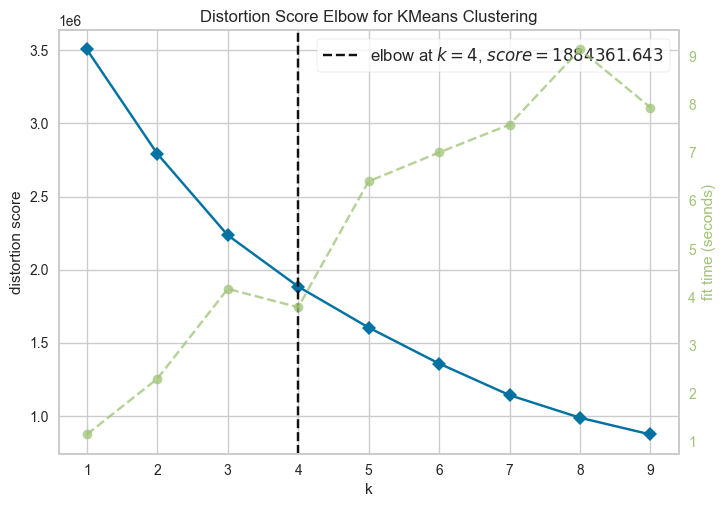

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [559]:
# Using the elbow method to find out the optimal number of cluster u
model = KMeans()
visualizer = KElbowVisualizer(model, k = (1, 10))

visualizer.fit(famd_features)
visualizer.show()

# Algorithmic Question

In [205]:
def enough_guards(n, m, g, entrances):

    # Use a dictionary to map entrances with guards
    assignments = {e: 0 for e in range(1, n + 1)}

    for i, e in enumerate(entrances):

        # Check if the entrance has not a guard
        if assignments[e] == 0:

            # Check for an available guard to be assigned
            if g > 0:
                assignments[e] = 1
                g -= 1
            else:
                # If we run out of guard we exit with a negative response
                return "NO"

        else:
            left_entrances = entrances[i+1:]

            # Check if the entrance can close
            if e not in left_entrances:
                del assignments[e]    # Close entrance
                g += 1                # Free the guard

    # If you got at the end of the loop we can return a positive response
    return "YES"

In [206]:
# First test
enough_guards(n=4, m=5, g=1, entrances=[1, 1, 3, 3, 3])

'YES'

In [207]:
# Second test
enough_guards(n=2, m=5, g=1, entrances=[ 1 , 2 , 1 , 2, 2 ])

'NO'